# Определение стоимости автомобилей

## Подготовка данных

In [109]:
import pandas as pd
import numpy as np
import random
random.seed(42)
import time
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette("flare")

In [110]:
# функция для расчета вероятности встретить тип переменной у конкретной модели

def prob_calc(df):
    probabilities = []
    model = df.index
    
    for values in model:
        probs = []
        count_sum = df.loc[df.index == values].sum().sum()
        count_prob = df.loc[df.index == values].sum()
        for ind in range(len(count_prob)):
            probs.append(count_prob[ind]/count_sum)
        probabilities.append(probs)
        
    return probabilities

In [111]:
try:
    df = pd.read_csv('/Users/anshilina/Documents/autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

In [112]:
display(df.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [114]:
df.describe(include='all')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


**Вывод:** Из описальных статистик видно, что в данных есть бессодержательные признаки. В частности, переменная `NumberOfPictures`, значения которой для всех наблюдений равны 0. Также стоит обратить внимание на переменные `DateCrawled`, `DateCreated`, `PostalCode`, `LastSeen` – они также кажутся бесполезными, поскольку дата создания анкеты, почтовый индекс владельца и проч. – все это не определяет стоимость авто. Скорее всего эти признаки будут удалены из массива.

Далее, из описательных статистик видно, что в данных есть выбросы. В частнисти, в переменных `Price`, `RegistrationYear`, `Power`.

### Выбросы

В целевой переменной `Price` 10,8 тыс. наблюдений с нулевой ценой. Эти данные похожи на выброс. Предлагается удалить их из выборки.

In [115]:
display(df['Price'].value_counts().head())

0       10772
500      5670
1500     5394
1000     4649
1200     4594
Name: Price, dtype: int64

In [116]:
df = df.query('0 < Price').copy()
df.shape[0]

343597

Ошибкой в данных являются автомобили, выпущенные после 2016 года, поскольку этот период еще не наступил на момент выгрузки данных (см. уникальные значения годов в переменной `DateCrawled`). Скорее всего значениями `9999` и проч. кодировались пропуски. Также выбросами являются ретро-автомобили, выпущенные после 1900 г. – их в выборке совсем немного.

In [117]:
print('Количество автомобилей выпущенных до 1900 г:', df.loc[df['RegistrationYear'] < 1900].shape[0])

Количество автомобилей выпущенных до 1900 г: 53


In [118]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
print('Годы:', df['DateCrawled'].dt.year.unique())

Годы: [2016]


In [119]:
df = df.loc[(df['RegistrationYear'] <= 2016) & (df['RegistrationYear'] > 1900)].copy()
display(df.shape)

(329765, 16)

В переменной `Power` также присутсвуют выбросы, которые искажают распределение, что видно из диаграммы разброса. Предлагается удалить 1% данных – часть нижней и часть верней границы.

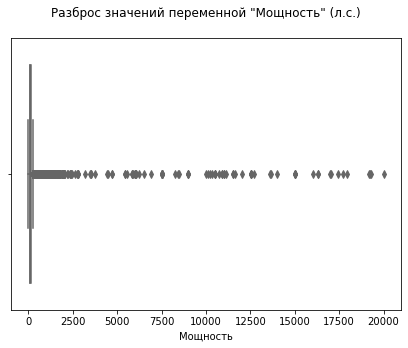

In [120]:
plt.figure(figsize=(7,5))
sns.boxplot(x = df['Power'], palette=color)
plt.xlabel('Мощность')
plt.title('Разброс значений переменной "Мощность" (л.с.)\n')
plt.show()

In [121]:
lower_quantile = df['Power'].quantile(0.005)
upper_quantile = df['Power'].quantile(0.995)

При этом мощность должна быть отличной от нуля, для авто – 30 л.с. минимум.

In [122]:
lower_quantile, upper_quantile

(0.0, 334.0)

In [123]:
df = df.query('30  < Power < @upper_quantile').copy()
df.shape[0]

294305

Изучим итоговое распределение.

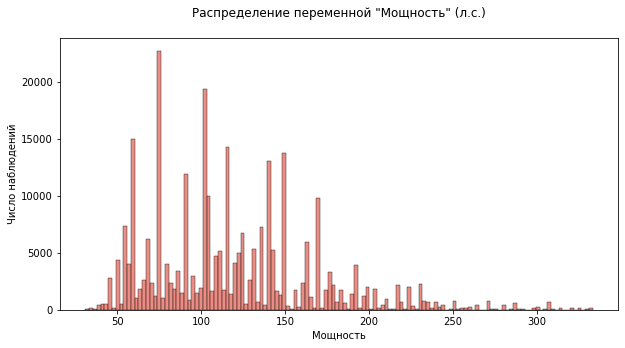

In [124]:
plt.figure(figsize=(10,5))
sns.histplot(x = df['Power'], color=color[1])
plt.xlabel('Мощность')
plt.ylabel('Число наблюдений')
plt.title('Распределение переменной "Мощность" (л.с.)\n')
plt.show()

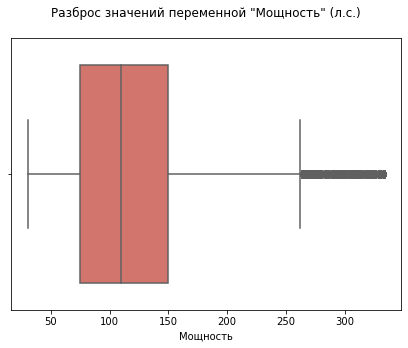

In [125]:
plt.figure(figsize=(7,5))
sns.boxplot(x = df['Power'], color=color[1])
plt.xlabel('Мощность')
plt.title('Разброс значений переменной "Мощность" (л.с.)\n')
plt.show()

Переменная `Kilometer` (пробег) – дискретная. Машины сгруппированы по пробегу. Нельзя сказать, что в данных есть выбросы – они выглядят вполне реалистично.

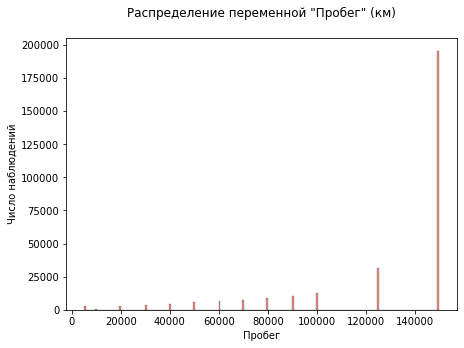

In [126]:
plt.figure(figsize=(7,5))
sns.histplot(x=df['Kilometer'], color=color[1])
plt.ylabel('Число наблюдений')
plt.xlabel('Пробег')
plt.title('Распределение переменной "Пробег" (км)\n')
plt.show()

In [127]:
display(df['Kilometer'].value_counts())

150000    195465
125000     31647
100000     12751
90000      10248
80000       8981
70000       7740
60000       6763
50000       5585
40000       4438
30000       3841
20000       3193
5000        2771
10000        882
Name: Kilometer, dtype: int64

### Оценка значимости переменных

Теперь оценим значимость переменных и отбросим ненужные. В частности, переменная `NumberOfPictures` принимает для всех наблюдений только одно значение – 0. Она бессодержательна, удалим её.

In [128]:
print('Уникальные значения переменной "NumberOfPictures":', df['NumberOfPictures'].unique())

Уникальные значения переменной "NumberOfPictures": [0]


Переменная `DateCrawled` показывает нам, что все анкеты были скачены из базы в 2016 году в марте-апреле. Она также бессодержательна и не принесёт пользы моделям. Удалим её. 

In [129]:
print('Годы:', df['DateCrawled'].dt.year.unique())
print('Месяцы:', df['DateCrawled'].dt.month.unique())

Годы: [2016]
Месяцы: [3 4]


Аналогичную ситуацию мы наблюдаем с переменной `LastSeen`. Последний раз пользователи были активны в 2016 году в марте-апреле. Удалим эту переменную, поскольку она не пригодится для предсказания цены.

In [130]:
df['LastSeen'] = pd.to_datetime(df['DateCrawled'], format='%Y-%m-%d %H:%M:%S')
print('Годы:', df['LastSeen'].dt.year.unique())
print('Месяцы:', df['LastSeen'].dt.month.unique())

Годы: [2016]
Месяцы: [3 4]


На первый взгляд переменная `DateCreated` более содержательная чем три признака, рассмотренные ранее. Все анкеты в массиве были созданы в 2016 или 2015 году в разные месяцы. Но большинство из пользователей разместили объявление в марте-апреле. Дисперсия в месяцах небольшая. Предлагается удалить эту переменную, чтобы она не сбивала модели при обучении.

In [131]:
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%d %H:%M:%S')
print('Годы:', df['DateCreated'].dt.year.unique())
print('Месяцы:', df['DateCreated'].dt.month.unique())

Годы: [2016 2015]
Месяцы: [ 3  4  2 11  1 12  9  8]


In [132]:
display(df['DateCreated'].dt.month.value_counts())

3     246195
4      47682
2        347
1         58
11         9
12         9
9          3
8          2
Name: DateCreated, dtype: int64

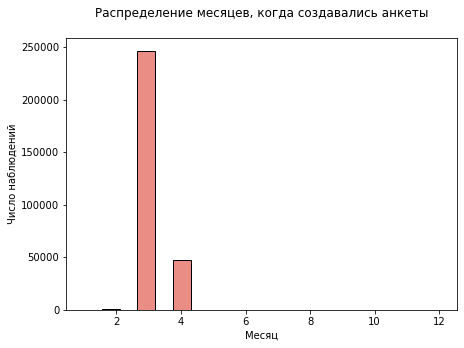

In [133]:
plt.figure(figsize=(7,5))
sns.histplot(x=df['DateCreated'].dt.month, color=color[1])
plt.ylabel('Число наблюдений')
plt.xlabel('Месяц')
plt.title('Распределение месяцев, когда создавались анкеты\n')
plt.show()

Таким образом, удалим переменные `NumberOfPictures`, `DateCrawled`, `DateCreated`, `PostalCode`, `LastSeen` из массива.

In [134]:
df = df.drop(['NumberOfPictures', 'DateCrawled', 'LastSeen', 'DateCreated', 'PostalCode'], axis=1).copy()

Посмотрим на оставшиеся числовые переменные в массиве и их распределение.

In [135]:
display(df.describe())

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,294305.00000,294305.000000,294305.000000,294305.000000,294305.000000
mean,4820.69502,2002.860947,119.638759,128430.165984,5.994869
std,4581.91345,6.438493,50.584339,36603.560360,3.583128
min,1.00000,1910.000000,31.000000,5000.000000,0.000000
25%,1300.00000,1999.000000,75.000000,125000.000000,3.000000
50%,3150.00000,2003.000000,110.000000,150000.000000,6.000000
75%,6980.00000,2007.000000,150.000000,150000.000000,9.000000
max,20000.00000,2016.000000,333.000000,150000.000000,12.000000


### Анализ дубликатов

Далее проанализируем дубликаты и удалим их при необходимости.

In [136]:
print('Кол-во дубликатов в массиве:', df.duplicated().sum())

Кол-во дубликатов в массиве: 23026


In [137]:
df.drop_duplicates(inplace=True)

Изучив категориальные переменные, мы убедились, что в значениях, которые принимают эти переменные, нет ошибок и повторов.

In [138]:
display(df['VehicleType'].value_counts())

sedan          75489
small          64029
wagon          53978
bus            24371
convertible    17255
coupe          13464
suv             9754
other           2322
Name: VehicleType, dtype: int64

In [139]:
display(df['Gearbox'].value_counts())

manual    213233
auto       52928
Name: Gearbox, dtype: int64

In [140]:
display(pd.unique(df['Model'].sort_values()))

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

In [141]:
display(df['FuelType'].value_counts())

petrol      171366
gasoline     79947
lpg           4213
cng            448
hybrid         196
other           53
electric        37
Name: FuelType, dtype: int64

In [142]:
display(df['Repaired'].value_counts())

no     203537
yes     27361
Name: Repaired, dtype: int64

In [143]:
display(df['Brand'].value_counts())

volkswagen        58352
opel              29791
bmw               29300
mercedes_benz     25089
audi              23096
ford              19160
renault           12870
peugeot            8683
fiat               7017
seat               5413
skoda              4577
mazda              4412
smart              4195
citroen            3950
toyota             3786
nissan             3765
hyundai            2894
mini               2724
volvo              2593
mitsubishi         2369
honda              2249
kia                1937
alfa_romeo         1864
suzuki             1841
sonstige_autos     1473
chevrolet          1355
chrysler           1083
dacia               743
subaru              615
daihatsu            576
jeep                551
saab                439
porsche             436
land_rover          432
jaguar              392
daewoo              385
lancia              358
rover               343
lada                148
trabant              23
Name: Brand, dtype: int64

**Вывод:** Мы проанализировали выбросы в данных и избавились от них. Также мы выявили бессодержательные переменные и удалили их. Наконец, мы обработали дубликаты. После первичного этапа пребодработки данных в массиве осталось белее 270 тыс. наблюдений.

In [144]:
print('Кол-во наблюдений в массиве:', df.shape)

Кол-во наблюдений в массиве: (271279, 11)


Визуализируем распределения числовых переменных.

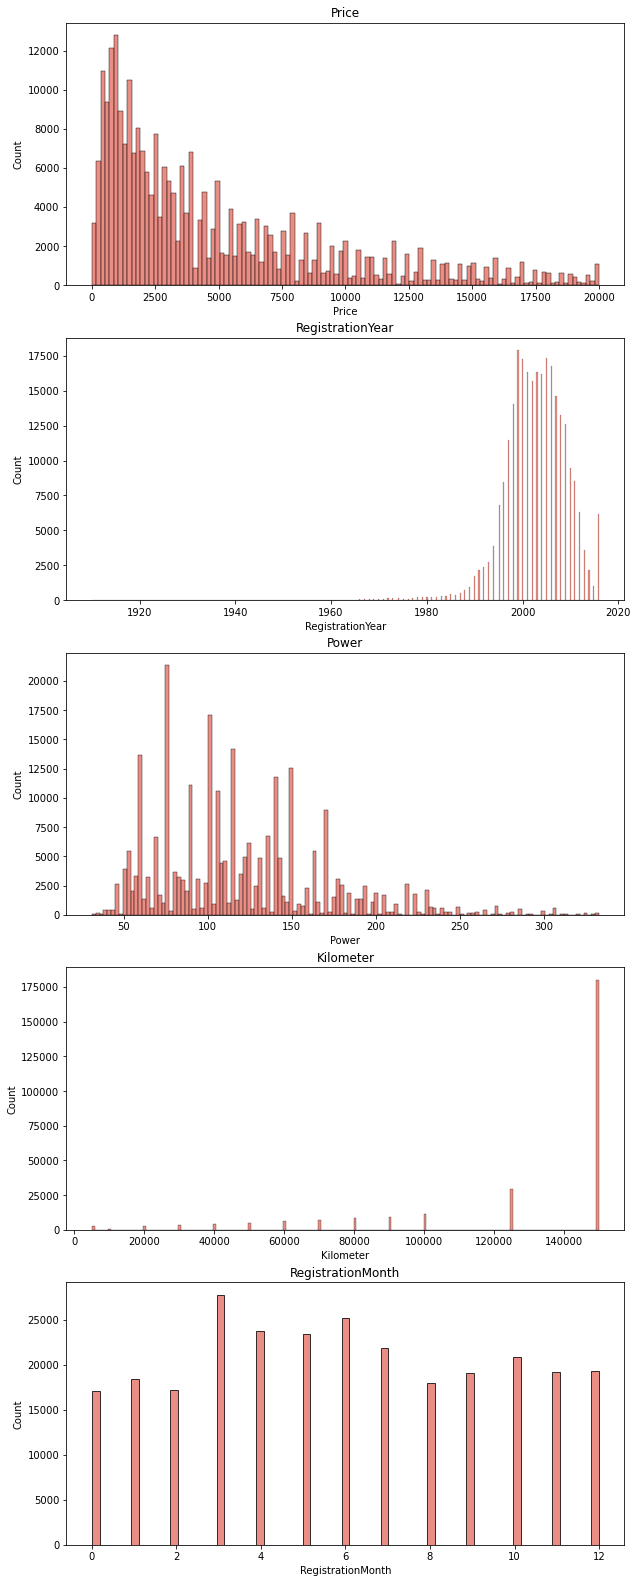

In [145]:
_, axs = plt.subplots(5, 1, figsize=(10,28))
axs = axs.ravel()
col_names = ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

for i in range(len(col_names)):
    ax = axs[i]
    sns.histplot(ax=ax, x=df[col_names[i]], data=df, color=color[1])
    ax.tick_params(axis='x')
    ax.set_title(col_names[i])

Посмотрим на распределение таргета в группах категориальных переменных.

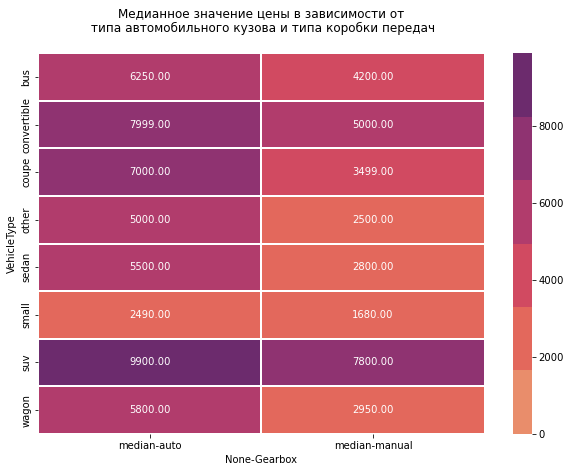

In [146]:
plt.figure(figsize=(10,7))
df_heatmap_gearbox = df.pivot_table(values='Price', index='VehicleType',columns='Gearbox', aggfunc={'median'})

sns.heatmap(df_heatmap_gearbox, annot=True, vmin=0, fmt='.2f', cmap = color, linewidths=0.01)
plt.title('Медианное значение цены в зависимости от\n типа автомобильного кузова и типа коробки передач\n')
plt.show()

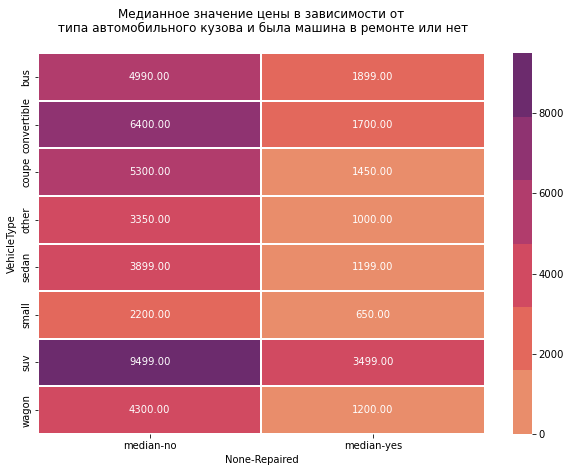

In [147]:
plt.figure(figsize=(10,7))
df_heatmap_repaired = df.pivot_table(values='Price', index='VehicleType',columns='Repaired', aggfunc={'median'})

sns.heatmap(df_heatmap_repaired, annot=True, vmin=0, fmt='.2f', cmap = color, linewidths=0.01)
plt.title('Медианное значение цены в зависимости от\n типа автомобильного кузова и была машина в ремонте или нет\n')
plt.show()

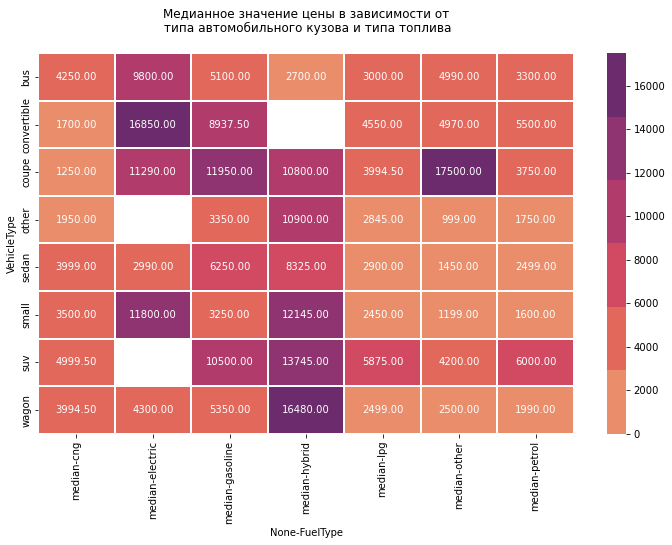

In [148]:
plt.figure(figsize=(12,7))
df_heatmap_fuel = df.pivot_table(values='Price', index='VehicleType',columns='FuelType', aggfunc={'median'})

sns.heatmap(df_heatmap_fuel, annot=True, vmin=0, fmt='.2f', cmap = color, linewidths=0.01)
plt.title('Медианное значение цены в зависимости от\n типа автомобильного кузова и типа топлива\n')
plt.show()

### Обработка пропущенных значений

В массиве много пропущенных значений. Перед обучением моделий необходимо их предобработать.

In [149]:
display(pd.DataFrame(round(df.isna().sum()), columns=['missing_val']).style.background_gradient(cmap='flare'))

,missing_val
Price,0
VehicleType,10617
RegistrationYear,0
Gearbox,5118
Power,0
Model,10393
Kilometer,0
RegistrationMonth,0
FuelType,15019
Brand,0


#### Model

Поскольку в зависимости от типа модели можно заполнить пропуски в переменных `VehicleType`, `Gearbox`, `FuelType` и `Repaired`, в первую очередь изучим пропуски в этой переменной. Пропуски в переменной `Model` составляют 4,2% от всех наблюдений. Предлагается их удалить.

In [150]:
print('Доля пропусков переменной "Model" от всех наблюдений:', df.loc[df['Model'].isna()].shape[0]/df.shape[0])

Доля пропусков переменной "Model" от всех наблюдений: 0.03831111143877705


In [151]:
df = df.loc[~df['Model'].isna()].copy()
display(df.shape)

(260886, 11)

In [152]:
display(pd.DataFrame(round(df.isna().sum()), columns=['missing_val']).style.background_gradient(cmap='flare'))

,missing_val
Price,0
VehicleType,9095
RegistrationYear,0
Gearbox,4469
Power,0
Model,0
Kilometer,0
RegistrationMonth,0
FuelType,12458
Brand,0


#### Repaired

В переменной `Repaired` предлагается заменить пропущенные значения на заглушку `unknown`.

In [153]:
display(df['Repaired'].value_counts())

no     198124
yes     25942
Name: Repaired, dtype: int64

In [154]:
df['Repaired'] = df['Repaired'].fillna('unknown')
display(df['Repaired'].unique())

array(['unknown', 'no', 'yes'], dtype=object)

In [155]:
display(pd.DataFrame(round(df.isna().sum()), columns=['missing_val']).style.background_gradient(cmap='flare'))

,missing_val
Price,0
VehicleType,9095
RegistrationYear,0
Gearbox,4469
Power,0
Model,0
Kilometer,0
RegistrationMonth,0
FuelType,12458
Brand,0


#### FuelType

Пропуски в переменной `FuelType` мы будем заменять в зависимости от того, какие значения принимает модель этого автомобиля. Для начала мы сгруппируем данные по переменным `Model` и `FuelType` в сводной таблице.

In [156]:
display(df['FuelType'].value_counts())

petrol      165569
gasoline     78185
lpg           3985
cng            436
hybrid         175
other           43
electric        35
Name: FuelType, dtype: int64

In [157]:
fuel_type = (
    df.loc[~df['FuelType'].isna(), ['Model', 'FuelType', 'Price']]
    .pivot_table(index=['Model'], columns='FuelType', values='Price', aggfunc={'count'})
)

fuel_type.columns = ['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol']
display(fuel_type.head())

,cng,electric,gasoline,hybrid,lpg,other,petrol
Model,,,,,,,
100,NaN,NaN,13.0,NaN,6.0,NaN,291.0
145,NaN,NaN,NaN,NaN,NaN,NaN,33.0
147,NaN,NaN,107.0,NaN,13.0,NaN,335.0
156,NaN,NaN,155.0,NaN,14.0,NaN,301.0
159,NaN,NaN,127.0,NaN,NaN,NaN,52.0


Далее мы расчитаем долю встречаемости каждого типа топлива в зависимоти от модели – это вероятность встретить тот или иной вид топлива у этой модели. Для рассчёта вероятностей воспользуемся функцией `prob_calc`, которая была инициализирована в начале.

In [158]:
probabilities = prob_calc(fuel_type)

In [159]:
fuel_type_probs = pd.DataFrame(probabilities, index=fuel_type.index, columns=fuel_type.columns)
display(fuel_type_probs.head())

,cng,electric,gasoline,hybrid,lpg,other,petrol
Model,,,,,,,
100,0.0,0.0,0.041935,0.0,0.019355,0.0,0.938710
145,0.0,0.0,0.000000,0.0,0.000000,0.0,1.000000
147,0.0,0.0,0.235165,0.0,0.028571,0.0,0.736264
156,0.0,0.0,0.329787,0.0,0.029787,0.0,0.640426
159,0.0,0.0,0.709497,0.0,0.000000,0.0,0.290503


Напишем функцию, с помощю которой мы будем заполнять пропущенные значения в типе топлива в зависимости от модели машины. Тип топлива будет выбираться случайным образом в зависимости от вероятности встретить этот тип у данной модели

In [160]:
def random_fuel(rows):
    model = rows['Model']
    
    for probs in fuel_type_probs.loc[fuel_type_probs.index == model].values:
        return np.random.choice(fuel_type_probs.columns.values, p=probs)


In [161]:
df.loc[df['FuelType'].isna(), 'FuelType'] = df.loc[df['FuelType'].isna()].apply(random_fuel, axis=1)

Стоит обратить внимание, что распределение этих переменных не изменилось.

In [162]:
display(df['FuelType'].value_counts())

petrol      174387
gasoline     81590
lpg           4190
cng            455
hybrid         183
other           44
electric        37
Name: FuelType, dtype: int64

In [163]:
display(pd.DataFrame(round(df.isna().sum()), columns=['missing_val']).style.background_gradient(cmap='flare'))

,missing_val
Price,0
VehicleType,9095
RegistrationYear,0
Gearbox,4469
Power,0
Model,0
Kilometer,0
RegistrationMonth,0
FuelType,0
Brand,0


#### Gearbox

По аналогии с типом топлива заполним пропуски в переменной `Gearbox` – тип коробки передач.

In [164]:
display(df['Gearbox'].value_counts())

manual    205459
auto       50958
Name: Gearbox, dtype: int64

In [165]:
gearbox_type = (
    df.loc[~df['Gearbox'].isna(), ['Gearbox', 'Model', 'Price']]
    .pivot_table(index=['Model'], columns='Gearbox', values='Price', aggfunc={'count'})
)


gearbox_type.columns = ['auto', 'manual']
display(gearbox_type.head())

,auto,manual
Model,,
100,55.0,270.0
145,NaN,34.0
147,21.0,438.0
156,39.0,460.0
159,25.0,162.0


In [166]:
probabilities = prob_calc(gearbox_type)

In [167]:
gearbox_type_probs = pd.DataFrame(probabilities, index=gearbox_type.index, columns=gearbox_type.columns)
display(gearbox_type_probs.head())

,auto,manual
Model,,
100,0.169231,0.830769
145,0.000000,1.000000
147,0.045752,0.954248
156,0.078156,0.921844
159,0.133690,0.866310


In [168]:
def random_gearbox(rows):
    model = rows['Model']
    
    for probs in gearbox_type_probs.loc[gearbox_type_probs.index == model].values:
        return np.random.choice(gearbox_type_probs.columns.values, p=probs)


In [169]:
df.loc[df['Gearbox'].isna(), 'Gearbox'] = df.loc[df['Gearbox'].isna()].apply(random_gearbox, axis=1)

In [170]:
display(pd.DataFrame(round(df.isna().sum()), columns=['missing_val']).style.background_gradient(cmap='flare'))

,missing_val
Price,0
VehicleType,9095
RegistrationYear,0
Gearbox,0
Power,0
Model,0
Kilometer,0
RegistrationMonth,0
FuelType,0
Brand,0


#### VehicleType

Теперь, используя ту же логику заполним пропуски в переменной `VehicleType` тип кузова.

In [171]:
display(df['VehicleType'].value_counts())

sedan          73146
small          61790
wagon          52426
bus            23694
convertible    16597
coupe          12796
suv             9222
other           2120
Name: VehicleType, dtype: int64

In [172]:
vehicle_type = (
    df.loc[~df['VehicleType'].isna(), ['VehicleType', 'Model', 'Price']]
    .pivot_table(index=['Model'], columns='VehicleType', values='Price', aggfunc={'count'})
)


vehicle_type.columns = ['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon']
display(vehicle_type.head())

,bus,convertible,coupe,other,sedan,small,suv,wagon
Model,,,,,,,,
100,NaN,1.0,2.0,NaN,222.0,NaN,NaN,94.0
145,NaN,NaN,1.0,1.0,12.0,17.0,NaN,NaN
147,NaN,NaN,23.0,7.0,319.0,84.0,NaN,2.0
156,NaN,NaN,2.0,NaN,235.0,2.0,NaN,247.0
159,NaN,NaN,NaN,NaN,50.0,NaN,NaN,133.0


In [173]:
probabilities = prob_calc(vehicle_type)

In [174]:
vehicle_type_probs = pd.DataFrame(probabilities, index=vehicle_type.index, columns=vehicle_type.columns)
display(vehicle_type_probs.head())

,bus,convertible,coupe,other,sedan,small,suv,wagon
Model,,,,,,,,
100,0.0,0.003135,0.006270,0.000000,0.695925,0.000000,0.0,0.294671
145,0.0,0.000000,0.032258,0.032258,0.387097,0.548387,0.0,0.000000
147,0.0,0.000000,0.052874,0.016092,0.733333,0.193103,0.0,0.004598
156,0.0,0.000000,0.004115,0.000000,0.483539,0.004115,0.0,0.508230
159,0.0,0.000000,0.000000,0.000000,0.273224,0.000000,0.0,0.726776


In [175]:
def random_vehicle(rows):
    model = rows['Model']
    
    for probs in vehicle_type_probs.loc[vehicle_type_probs.index == model].values:
        return np.random.choice(vehicle_type_probs.columns.values, p=probs)

In [176]:
df.loc[df['VehicleType'].isna(), 'VehicleType'] = df.loc[df['VehicleType'].isna()].apply(random_vehicle, axis=1)

In [177]:
display(pd.DataFrame(round(df.isna().sum()), columns=['missing_val']).style.background_gradient(cmap='flare'))

,missing_val
Price,0
VehicleType,0
RegistrationYear,0
Gearbox,0
Power,0
Model,0
Kilometer,0
RegistrationMonth,0
FuelType,0
Brand,0


In [178]:
display(df.head())

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no


In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260886 entries, 2 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              260886 non-null  int64 
 1   VehicleType        260886 non-null  object
 2   RegistrationYear   260886 non-null  int64 
 3   Gearbox            260886 non-null  object
 4   Power              260886 non-null  int64 
 5   Model              260886 non-null  object
 6   Kilometer          260886 non-null  int64 
 7   RegistrationMonth  260886 non-null  int64 
 8   FuelType           260886 non-null  object
 9   Brand              260886 non-null  object
 10  Repaired           260886 non-null  object
dtypes: int64(5), object(6)
memory usage: 23.9+ MB


**Вывод:** Нам удалось заполнить пропуски в данных. Для этого мы использовали разные техники, в т.ч. заглушку для переменной `Repaired` и заполнение случайным значением в зависимости от вероятности его встретить в данной модели машины. 

## Обучение моделей

Разделим выборку на обучающую и тестовую в соотношении 75:25.

In [180]:
features = df.drop(['Price'], axis=1)
target = df['Price']

features_train, features_test, target_train, target_test = train_test_split(
                features, target, test_size=0.25, random_state=42, shuffle=True)

Теперь создадим трансформер, который позволит нам отдельно обрабатывать категориальные и числовые переменные. Числовые перемеменные мы будем скалировать, а из категориальных сделаем дамми-переменные.

In [181]:
numerical = df.select_dtypes(include='int64').columns.drop('Price').values
categorical = df.select_dtypes(include='object').columns.values

transformer = make_column_transformer((StandardScaler(), numerical), 
                                      (OneHotEncoder(sparse=False, categories='auto', drop='first', 
                                                     handle_unknown='ignore'), categorical), 
                                      remainder='passthrough')

# transformed = transformer.fit_transform(features)
# transformed_df = pd.DataFrame(transformed, index=features.index)

#### Dummy модель

Обучим дамми-модель и оценим качество на тренировочной выборке.

In [182]:
pipe_dummy = Pipeline([('preprocess', transformer),
                       ('dummy_model', DummyRegressor())])

In [183]:
start_time = time.time()
pipe_dummy.fit(features_train, target_train)
time_fit_dummy = time.time() - start_time

In [184]:
start_time = time.time()
pred_dummy = pipe_dummy.predict(features_train)
time_pred_dummy = time.time() - start_time

In [185]:
dummy_rmse = np.mean(-cross_val_score(pipe_dummy, features_train, target_train, cv=5, scoring='neg_root_mean_squared_error'))
print('RMSE:', dummy_rmse)

RMSE: 4596.909897956991


#### Линейная регрессия

Далее посмотрим на качество линейной регрессии. Оно явно лучше, чем качество дамми-модели.

In [186]:
pipe_lin = Pipeline([('preprocess', transformer),
                     ('lin_model', LinearRegression())])

In [187]:
start_time = time.time()
pipe_lin.fit(features_train, target_train)
time_fit_lin = time.time() - start_time

In [188]:
start_time = time.time()
pred_lin = pipe_lin.predict(features_train)
time_pred_lin = time.time() - start_time

In [189]:
lin_rmse = np.mean(-cross_val_score(pipe_lin, features_train, target_train, cv=5, scoring='neg_root_mean_squared_error'))
print('RMSE:', lin_rmse)

RMSE: 2560.68879879158


#### Дерево решений

In [190]:
transformer_trees = make_column_transformer((OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan), 
                                             categorical), remainder='passthrough')

In [191]:
pipe_tree = Pipeline([('preprocess', transformer_trees),
                      ('imputer', SimpleImputer(strategy='most_frequent')),
                      ('tree_model', DecisionTreeRegressor(random_state=42))])

Дерево решений обучается быстрее. При этом качество модели на кросс-валидации лучше.

In [192]:
%%time
pipe_tree.fit(features_train, target_train)

CPU times: user 2.43 s, sys: 261 ms, total: 2.69 s
Wall time: 1.51 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  array(['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired'],
      dtype=object))])),
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('tree_model', DecisionTreeRegressor(random_state=42))])

In [193]:
tree_rmse = np.mean(-cross_val_score(pipe_tree, features_train, target_train, cv=5, scoring='neg_root_mean_squared_error'))
print('RMSE:', tree_rmse)

RMSE: 2125.563158093806


Подберем параметры, в т.ч. ограничим глубину леса.

In [194]:
max_depth = [int(x) for x in np.linspace(10, 150, num = 20)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]

tree_params = {
    'tree_model__max_depth': max_depth,
    'tree_model__min_samples_split': min_samples_split,
    'tree_model__min_samples_leaf': min_samples_leaf,
}

In [195]:
tree_random = RandomizedSearchCV(estimator=pipe_tree, param_distributions=tree_params, 
                                 scoring='neg_root_mean_squared_error', n_iter=10, cv=3, verbose=2, random_state=42)

In [196]:
start_time = time.time()
tree_random.fit(features_train, target_train)
time_grid_tree = time.time() - start_time

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END tree_model__max_depth=None, tree_model__min_samples_leaf=2, tree_model__min_samples_split=5; total time=   1.0s
[CV] END tree_model__max_depth=None, tree_model__min_samples_leaf=2, tree_model__min_samples_split=5; total time=   1.0s
[CV] END tree_model__max_depth=None, tree_model__min_samples_leaf=2, tree_model__min_samples_split=5; total time=   1.0s
[CV] END tree_model__max_depth=142, tree_model__min_samples_leaf=1, tree_model__min_samples_split=5; total time=   1.0s
[CV] END tree_model__max_depth=142, tree_model__min_samples_leaf=1, tree_model__min_samples_split=5; total time=   1.0s
[CV] END tree_model__max_depth=142, tree_model__min_samples_leaf=1, tree_model__min_samples_split=5; total time=   1.0s
[CV] END tree_model__max_depth=24, tree_model__min_samples_leaf=1, tree_model__min_samples_split=2; total time=   1.1s
[CV] END tree_model__max_depth=24, tree_model__min_samples_leaf=1, tree_model__min_samples_split=

In [197]:
print('Время подбора парамеров:', time_grid_tree)

Время подбора парамеров: 31.214763164520264


In [198]:
time_fit_tree = tree_random.cv_results_['mean_fit_time'][tree_random.best_index_]
print('Время обучения лучшей модели:', time_fit_tree)

Время обучения лучшей модели: 0.7632622718811035


In [199]:
start_time = time.time()
pred_tree = tree_random.predict(features_train)
time_pred_tree = time.time() - start_time

In [200]:
display(tree_random.best_params_)

{'tree_model__min_samples_split': 2,
 'tree_model__min_samples_leaf': 4,
 'tree_model__max_depth': 17}

In [201]:
tree_rmse = np.mean(-cross_val_score(tree_random.best_estimator_, features_train, target_train, 
                                     cv=5, scoring='neg_root_mean_squared_error'))
print('RMSE:', tree_rmse)

RMSE: 1825.8919294312236


Модель показывает лучшее качество, чем линейная регрессия.

#### Случайный лес

Примерное время обучения случайного леса – чуть больше 1 мин.

In [202]:
pipe_forest = Pipeline([('preprocess', transformer_trees),
                        ('imputer', SimpleImputer(strategy='most_frequent')),
                        ('forest_model', RandomForestRegressor(random_state=42))])

In [203]:
%%time
pipe_forest.fit(features_train, target_train)

CPU times: user 1min 5s, sys: 1.29 s, total: 1min 6s
Wall time: 1min 6s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  array(['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired'],
      dtype=object))])),
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('forest_model', RandomForestRegressor(random_state=42))])

In [204]:
forest_rmse = np.mean(-cross_val_score(pipe_forest, features_train, target_train, cv=3, scoring='neg_root_mean_squared_error'))
print('RMSE:', forest_rmse)

RMSE: 1648.7797091326204


Оценка на кросс-валидации без подбора параметров лучше, чем у дерева решений. Попробуем улучшить результаты, подобрав параметры для случайного леса.

In [205]:
max_depth = [int(x) for x in np.linspace(10, 30, num = 20)]
max_depth.append(None)
n_estimators = [int(x) for x in np.linspace(10, 50, num = 10)]

forest_params = {
    'forest_model__max_depth': max_depth,
    'forest_model__n_estimators': n_estimators,
}

In [206]:
forest_random = RandomizedSearchCV(estimator=pipe_forest, param_distributions=forest_params, scoring='neg_root_mean_squared_error', 
                                   n_iter=5, cv=3, verbose=2, random_state=42)

In [207]:
start_time = time.time()
forest_random.fit(features_train, target_train)
time_grid_forest = time.time() - start_time

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END forest_model__max_depth=13, forest_model__n_estimators=10; total time=   3.4s
[CV] END forest_model__max_depth=13, forest_model__n_estimators=10; total time=   3.2s
[CV] END forest_model__max_depth=13, forest_model__n_estimators=10; total time=   3.2s
[CV] END forest_model__max_depth=27, forest_model__n_estimators=18; total time=   8.9s
[CV] END forest_model__max_depth=27, forest_model__n_estimators=18; total time=   9.0s
[CV] END forest_model__max_depth=27, forest_model__n_estimators=18; total time=   8.8s
[CV] END forest_model__max_depth=18, forest_model__n_estimators=27; total time=  10.6s
[CV] END forest_model__max_depth=18, forest_model__n_estimators=27; total time=  10.4s
[CV] END forest_model__max_depth=18, forest_model__n_estimators=27; total time=  10.5s
[CV] END forest_model__max_depth=30, forest_model__n_estimators=50; total time=  24.8s
[CV] END forest_model__max_depth=30, forest_model__n_estimators=50; to

In [208]:
time_fit_forest = forest_random.cv_results_['mean_fit_time'][forest_random.best_index_]
print('Время обучения лучшей модели:', time_fit_forest)

Время обучения лучшей модели: 9.932096083958944


In [209]:
start_time = time.time()
pred_forest = forest_random.predict(features_train)
time_pred_forest = time.time() - start_time

In [210]:
display(forest_random.best_params_)

{'forest_model__n_estimators': 27, 'forest_model__max_depth': 18}

In [211]:
forest_rmse = np.mean(-cross_val_score(forest_random.best_estimator_, features_train, target_train, cv=3, 
                                       scoring='neg_root_mean_squared_error'))
print('RMSE:', forest_rmse)

RMSE: 1636.8549139444392


Модель подбирала параметры более 2 мин. При этом мы немного улучшили качество модели.

#### CatBoost Regressor

Теперь рассмотрим модели градиентного бустинга. Модель CatBoost Regressor обучается быстрее, чем случайный лес – 11-12 сек. При этом качество на кросс-валидации даже без подбора параметров лучше, чем у случайном лесе. Подбор параметров занял примерно 8 мин и позволил еще повысить качество модели. Время предсказаний – меньше секунды.

In [212]:
transformer_cat = make_column_transformer((OrdinalEncoder(dtype='int64'), categorical), remainder='passthrough')
fit_features_train = transformer_cat.fit(features_train)
transformed_features_train = pd.DataFrame(fit_features_train.transform(features_train), 
                                          index=features_train.index, 
                                          columns=fit_features_train.get_feature_names_out())

In [213]:
cat_boost = CatBoostRegressor(random_seed=42, loss_function='RMSE', silent=True)

In [214]:
%%time
cat_boost.fit(transformed_features_train, target_train)

CPU times: user 51.3 s, sys: 6.92 s, total: 58.2 s
Wall time: 11.1 s


In [215]:
cat_rmse = np.mean(-cross_val_score(cat_boost, transformed_features_train, target_train, cv=3, 
                                    scoring='neg_root_mean_squared_error'))
print('RMSE:', cat_rmse)

RMSE: 1559.5291488981127


Далее подберем параметры для модели.

In [216]:
depth = [4,5,6,7,8,9, 10]
learning_rate = [0.03, 0.1]

cat_params = {'learning_rate': learning_rate,
              'depth':depth,
}

In [217]:
cat_boost_grid = GridSearchCV(estimator=cat_boost, param_grid=cat_params, 
                              scoring='neg_root_mean_squared_error', cv=3, verbose=2)

In [218]:
start_time = time.time()
cat_boost_grid.fit(transformed_features_train, target_train)
time_grid_cat = time.time() - start_time

Fitting 3 folds for each of 14 candidates, totalling 42 fits
[CV] END ........................depth=4, learning_rate=0.03; total time=   6.1s
[CV] END ........................depth=4, learning_rate=0.03; total time=   6.1s
[CV] END ........................depth=4, learning_rate=0.03; total time=   6.3s
[CV] END .........................depth=4, learning_rate=0.1; total time=   6.2s
[CV] END .........................depth=4, learning_rate=0.1; total time=   6.0s
[CV] END .........................depth=4, learning_rate=0.1; total time=   6.5s
[CV] END ........................depth=5, learning_rate=0.03; total time=   8.3s
[CV] END ........................depth=5, learning_rate=0.03; total time=   8.6s
[CV] END ........................depth=5, learning_rate=0.03; total time=   7.5s
[CV] END .........................depth=5, learning_rate=0.1; total time=   6.9s
[CV] END .........................depth=5, learning_rate=0.1; total time=   7.0s
[CV] END .........................depth=5, learn

In [219]:
time_fit_cat = cat_boost_grid.cv_results_['mean_fit_time'][cat_boost_grid.best_index_]
print('Время обучения лучшей модели:', time_fit_cat)

Время обучения лучшей модели: 12.577220757802328


In [220]:
display(cat_boost_grid.best_params_)

{'depth': 9, 'learning_rate': 0.1}

In [221]:
start_time = time.time()
pred_cat = cat_boost_grid.predict(transformed_features_train)
time_pred_cat = time.time() - start_time

In [222]:
cat_rmse = np.mean(-cross_val_score(cat_boost_grid.best_estimator_, transformed_features_train, target_train, 
                                    cv=3, scoring='neg_root_mean_squared_error'))
print('RMSE:', cat_rmse)

RMSE: 1523.5859296656472


#### LightGBM Regressor

Эта модель по всем показателям хороша: высокая скорость обучения, высокая скорость подбора параметров и высокая скорость предсказания. Качество модели чуть ниже, чем у модели CatBoost.

In [223]:
features_train[categorical] = features_train[categorical].astype('category')

In [224]:
lgbm = LGBMRegressor(random_state=42)

In [225]:
%%time
lgbm.fit(features_train, target_train)

CPU times: user 4.24 s, sys: 363 ms, total: 4.61 s
Wall time: 661 ms


LGBMRegressor(random_state=42)

In [226]:
lgbm_rmse = np.mean(-cross_val_score(lgbm, features_train, target_train, cv=3, scoring='neg_root_mean_squared_error'))
print('RMSE:', lgbm_rmse)

RMSE: 1567.9300481455732


Качество на кросс-валидации хуже, чем у модели CatBoost. Попробуем подобрать параметры.

In [227]:
max_depth = [int(x) for x in np.linspace(10, 40, num = 10)]
n_estimators = [int(x) for x in np.linspace(100, 300, num = 20)]

lgbm_params = {
    'max_depth': max_depth,
    'n_estimators': n_estimators,
}

In [228]:
lgbm_random = RandomizedSearchCV(estimator=lgbm, param_distributions=lgbm_params, 
                                 scoring='neg_root_mean_squared_error', n_iter=10, cv=3, verbose=2, random_state=42)

In [229]:
start_time = time.time()
lgbm_random.fit(features_train, target_train)
time_grid_lgbm = time.time() - start_time

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .....................max_depth=23, n_estimators=257; total time=   1.2s
[CV] END .....................max_depth=23, n_estimators=257; total time=   1.2s
[CV] END .....................max_depth=23, n_estimators=257; total time=   1.1s
[CV] END .....................max_depth=10, n_estimators=257; total time=   1.2s
[CV] END .....................max_depth=10, n_estimators=257; total time=   1.1s
[CV] END .....................max_depth=10, n_estimators=257; total time=   1.2s
[CV] END .....................max_depth=13, n_estimators=205; total time=   1.0s
[CV] END .....................max_depth=13, n_estimators=205; total time=   1.0s
[CV] END .....................max_depth=13, n_estimators=205; total time=   1.1s
[CV] END .....................max_depth=33, n_estimators=289; total time=   1.5s
[CV] END .....................max_depth=33, n_estimators=289; total time=   1.3s
[CV] END .....................max_depth=33, n_es

In [230]:
time_fit_lgbm = lgbm_random.cv_results_['mean_fit_time'][lgbm_random.best_index_]
print('Время обучения лучшей модели:', time_fit_lgbm)

Время обучения лучшей модели: 1.0082132816314697


In [231]:
display(lgbm_random.best_params_)

{'n_estimators': 289, 'max_depth': 33}

In [232]:
start_time = time.time()
pred_lbbm = lgbm_random.predict(features_train)
time_pred_lgbm = time.time() - start_time

In [233]:
lgbm_rmse = np.mean(-cross_val_score(lgbm_random.best_estimator_, features_train, target_train, cv=3, scoring='neg_root_mean_squared_error'))
print('RMSE:', lgbm_rmse)

RMSE: 1532.6351722170912


## Анализ моделей

Теперь сравним модели по критериям заказчика: 

* качество предсказания
* время обучения модели
* время предсказания модели


In [234]:
print('Качество дамми-модели на кросс-валидации:', round(dummy_rmse, 2))
print(f'Время обучения дамми-модели {round(time_fit_dummy, 2)} сек, время предсказания {round(time_pred_dummy, 2)} сек')

Качество дамми-модели на кросс-валидации: 4596.91
Время обучения дамми-модели 1.23 сек, время предсказания 0.83 сек


Все модели предсказывают данные лучше, чем дамми-модель.

In [235]:
print('Качество LightGBM на кросс-валидации:', round(lgbm_rmse, 2))
print(f'Время обучения LightGBM Regressor на трейне {round(time_fit_lgbm, 2)} сек, время подбора параметров {round(time_grid_lgbm, 2)} сек, время предсказаний {round(time_pred_lgbm, 2)} сек')
print()

print('Качество CatBoost на кросс-валидации:', round(cat_rmse, 2))
print(f'Время обучения CatBoost Regressor на трейне {round(time_fit_cat, 2)} сек, время подбора параметров {round(time_grid_cat/60, 2)} мин, время предсказаний {round(time_pred_cat, 2)} сек')
print()

print('Качество случайного леса на кросс-валидации:', round(forest_rmse, 2))
print(f'Время обучения случайного леса {round(time_fit_forest, 2)} сек, время подбора параметров {round(time_grid_forest/60, 2)} мин, время предсказания {round(time_pred_forest, 2)} сек')
print()

print('Качество дерева решений на кросс-валидации:', round(tree_rmse, 2))
print(f'Время обучения дерева решений {round(time_fit_tree, 2)} сек, время подбора параметров {round(time_grid_tree, 2)} сек, время предсказания {round(time_pred_tree, 2)} сек')
print()

print('Качество линейной регрессии на кросс-валидации:', round(lin_rmse, 2))
print(f'Время обучения линейной регрессии {round(time_fit_lin, 2)} сек, время предсказания {round(time_pred_lin, 2)} сек')
print()

Качество LightGBM на кросс-валидации: 1532.64
Время обучения LightGBM Regressor на трейне 1.01 сек, время подбора параметров 33.52 сек, время предсказаний 0.95 сек

Качество CatBoost на кросс-валидации: 1523.59
Время обучения CatBoost Regressor на трейне 12.58 сек, время подбора параметров 7.32 мин, время предсказаний 0.27 сек

Качество случайного леса на кросс-валидации: 1636.85
Время обучения случайного леса 9.93 сек, время подбора параметров 2.84 мин, время предсказания 1.8 сек

Качество дерева решений на кросс-валидации: 1825.89
Время обучения дерева решений 0.76 сек, время подбора параметров 31.21 сек, время предсказания 0.33 сек

Качество линейной регрессии на кросс-валидации: 2560.69
Время обучения линейной регрессии 4.83 сек, время предсказания 0.91 сек



Исходя из качества модели на тренировочной выборке, скорости обучения, скорости подбора параметров (с учетом метода подбора параметров) и времени предсказания предлагается использовать CatBoost Regressor для предсказания цены автомобиля.

In [236]:
transformed_features_test = transformer_cat.transform(features_test)
transformed_features_test = pd.DataFrame(transformed_features_test, 
                                         index=features_test.index, 
                                         columns=fit_features_train.get_feature_names_out())

In [237]:
params = cat_boost_grid.best_params_
final_model = CatBoostRegressor(random_seed=42, loss_function='RMSE', silent=True).set_params(**params)
final_model.fit(transformed_features_train, target_train)

In [238]:
print('Качество модели CatBoost на тестовой выборке:', np.sqrt(mean_squared_error(target_test, final_model.predict(transformed_features_test))))

Качество модели CatBoost на тестовой выборке: 1530.9174043225862


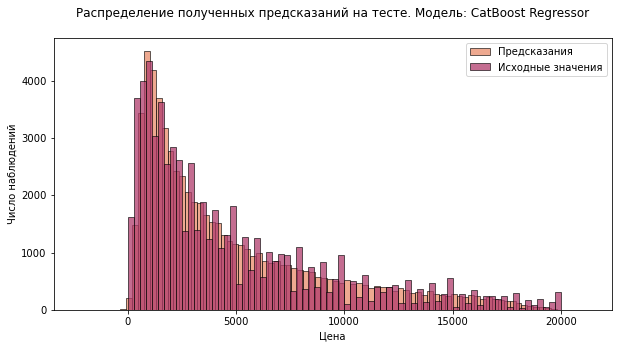

In [239]:
plt.figure(figsize=(10,5))
sns.histplot(x=final_model.predict(transformed_features_test), color=color[0], label='Предсказания')
sns.histplot(x=target_test, color=color[3], label='Исходные значения')
plt.ylabel('Число наблюдений')
plt.xlabel('Цена')
plt.title('Распределение полученных предсказаний на тесте. Модель: CatBoost Regressor\n')
plt.legend()
plt.show()

## Вывод

На первом этапе подготовки данных были выбраны переменные, которые будут использоваться для предсказания стоимости автомобиля: `VehicleType`, `RegistrationYear`, `Gearbox`, `Power`, `Model`, `Kilometer`, `RegistrationMonth`, `FuelType`, `Brand`, `Repaired`. Также из данных были удалены выбросы и дубликаты. На заключительном этапе в переменных были заполнены пропуски. 

Далее были обучены пять моделей машинного обучения: линейная регрессия, дерево решений, случайный лес, CatBoostRegressor и LGBMRegressor. Предсказания моделей сравнивались с предсказаниями дамми-регрессора. 

В результате анализа скорости обучения, скорости подбора параметров, скорости предсказания и главное – качества предсказаний на обучающей выборки была выбрана модель CatBoostRegressor. Её рекомендуется использовать для разрабатки приложения, которое будет предсказывать стоимость автомобиля.